In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import pickle
import glob

import matplotlib.pyplot as plt
import re
import ast

Load all_data_siegel --> Select only correct trials --> convert seconds to indices --> drop nan

In [2]:
with open("/home/aarghavan/nasShare/projects/labdul/Data_siegel/all_data_siegel.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(data.keys() if isinstance(data, dict) else data)
data

<class 'dict'>
dict_keys(['trial', 'unit', 'session', 'spiketimes', 'trialsNeuron'])


{'trial': [{'delsac':               trial  taskTrial  bhvTrial  condition      task      outcome  \
   [100725.2]        2          2         2         54  [delsac]  [choiceErr]   
   [100725.3]        3          3         3         34  [delsac]    [correct]   
   [100725.5]        5          5         5         29  [delsac]    [correct]   
   [100725.6]        6          6         6         30  [delsac]    [correct]   
   [100725.7]        7          7         7        133  [delsac]    [correct]   
   ...             ...        ...       ...        ...       ...          ...   
   [100725.217]    217        217       217         21  [delsac]    [correct]   
   [100725.219]    219        219       219         15  [delsac]    [correct]   
   [100725.224]    224        224       224         67  [delsac]    [correct]   
   [100725.225]    225        225       225        109  [delsac]  [choiceErr]   
   [100725.226]    226        226       226        128  [delsac]    [correct]   
   
     

In [3]:
# select only correct trials and no bad trials

filtered_delsac = []
for sess in data["trial"]:
    if "delsac" in sess:
        df = sess["delsac"]
        if all(col in df.columns for col in ["correct", "badTrials", "badTimingTrials"]):
            df_filtered = df[(df["correct"] == 1) & (df["badTrials"] == 0) & (df["badTimingTrials"] == 0)].copy()
            filtered_delsac.append({"delsac": df_filtered})

print(len(filtered_delsac))                 # still 53 (one per session)
filtered_delsac[0]["delsac"]


53


,trial,taskTrial,bhvTrial,condition,task,outcome,correct,reactionTime,numRewards,mapColors,...,responseHeld,outcomeTime,rewardOn,rewardOff,feedbackOff,trialEnd,session,trialRefTimes,badTimingTrials,badTrials
[100725.3],3,3,3,34,[delsac],[correct],1,0.191925,3,"(0, 90, 150, 150, -60, 0)",...,3.504375,3.504375,"(3.5217499999999973, 3.627324999999999, 3.7323...","(3.5460749999999948, 3.6519249999999985, 3.757...",NaN,3.859000,[100725],45.051425,0,0
[100725.5],5,5,5,29,[delsac],[correct],1,0.201000,3,"(-180, -150, 60, -150, 150, 120)",...,3.514500,3.514500,"(3.5274, 3.6321000000000083, 3.737550000000013...","(3.5516500000000093, 3.6570000000000107, 3.762...",NaN,3.864675,[100725],64.210850,0,0
[100725.6],6,6,6,30,[delsac],[correct],1,0.208550,3,"(-180, 90, -180, -120, 150, -120)",...,3.524325,3.524325,"(3.537549999999996, 3.642425000000003, 3.74792...","(3.5618999999999943, 3.667349999999999, 3.7726...",NaN,3.875050,[100725],71.490650,0,0
[100725.7],7,7,7,133,[delsac],[correct],1,0.125275,3,"(-120, -120, -120, 0, 120, 30)",...,3.434250,3.434250,"(3.4474249999999955, 3.552224999999993, 3.6573...","(3.471724999999992, 3.5770749999999936, 3.6822...",NaN,3.784175,[100725],78.850425,0,0
[100725.8],8,8,8,107,[delsac],[correct],1,0.250775,3,"(-90, 120, 90, -90, -120, -90)",...,3.564100,3.564100,"(3.5773999999999972, 3.6822250000000025, 3.787...","(3.6017500000000098, 3.7070750000000032, 3.812...",NaN,3.914400,[100725],86.160225,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[100725.216],216,216,216,120,[delsac],[correct],1,0.237575,3,"(0, -90, 60, 0, 120, -60)",...,3.543950,3.543950,"(3.557350000000042, 3.6623500000000604, 3.7678...","(3.581875000000082, 3.687225000000126, 3.79265...",NaN,3.894475,[100725],1636.384975,0,0
[100725.217],217,217,217,21,[delsac],[correct],1,0.175400,3,"(-60, 60, 60, 150, 30, 90)",...,3.484150,3.484150,"(3.497400000000198, 3.6023250000000644, 3.7078...","(3.5217750000001615, 3.6271250000002055, 3.732...",NaN,3.834650,[100725],1643.934750,0,0
[100725.219],219,219,219,15,[delsac],[correct],1,0.193675,3,"(-30, -30, -120, 90, -180, 0)",...,3.504525,3.504525,"(3.5173999999999523, 3.622524999999996, 3.7275...","(3.541774999999916, 3.647175000000061, 3.75257...",NaN,3.854850,[100725],1659.044275,0,0
[100725.224],224,224,224,67,[delsac],[correct],1,0.194450,3,"(-90, 60, -60, -60, -90, -150)",...,3.504200,3.504200,"(3.5174999999999272, 3.6222250000000713, 3.727...","(3.5417999999999665, 3.647224999999935, 3.7527...",NaN,3.855125,[100725],1699.243125,0,0


In [4]:
# convert seconds to indices
# based on 1 kHz sampling, -2.5 to +3.5 s window (6001 samples)

TIME_COLS = ['trialStart','fixptOn','fixationTime','fixptOn2',
             'stimOn','stimOff','targetOn','targetOff','fixptOff',
             'responseTime','responseDone']  # skip 'targetPos'

FS = 1000.0     # Hz
T_START = -2.5  # s
N = 6001        # samples (−2.5 … +3.5 at 1 kHz)

def time_to_idx(series, fs=FS, t_start=T_START, n=N):
    # i = round((t - t_start) * fs)
    s = pd.to_numeric(series, errors="coerce")
    idx = np.rint((s - t_start) * fs)
    # keep NaN for invalid / missing
    idx[~np.isfinite(s)] = np.nan
    # out-of-window -> NaN
    idx[(idx < 0) | (idx > (n - 1))] = np.nan
    return idx.astype(float)

# Apply to every session's delsac DataFrame (correct trials)
for sess in filtered_delsac:
    if "delsac" not in sess: 
        continue
    df = sess["delsac"]
    for col in TIME_COLS:
        if col in df.columns:
            df[f"{col}_idx"] = time_to_idx(df[col])

# Optional: quick sanity checks per session
for k, sess in enumerate(filtered_delsac[:3]):  # first 3 sessions as a spot-check
    df = sess["delsac"]
    cols_present = [c for c in TIME_COLS if f"{c}_idx" in df.columns]
    if "stimOn" in df.columns and "stimOn_idx" in df.columns:
        print(f"session {k}: stimOn ~ {df['stimOn'].iloc[:3].tolist()} -> idx {df['stimOn_idx'].iloc[:3].tolist()}")
    else:
        print(f"session {k}: (stimOn missing or no idx)")


session 0: stimOn ~ [0, 0, 0] -> idx [2500.0, 2500.0, 2500.0]
session 1: stimOn ~ [0, 0, 0] -> idx [2500.0, 2500.0, 2500.0]
session 2: stimOn ~ [0, 0, 0] -> idx [2500.0, 2500.0, 2500.0]


In [5]:
filtered_delsac[50]['delsac'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, ['101024.1316'] to ['101024.1669']
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trial             157 non-null    uint16 
 1   taskTrial         157 non-null    uint16 
 2   bhvTrial          157 non-null    uint16 
 3   condition         157 non-null    uint8  
 4   task              157 non-null    object 
 5   outcome           157 non-null    object 
 6   correct           157 non-null    uint8  
 7   reactionTime      157 non-null    float64
 8   numRewards        157 non-null    uint8  
 9   mapColors         157 non-null    object 
 10  mapDirections     157 non-null    object 
 11  targetPos         157 non-null    object 
 12  trialStart        157 non-null    float64
 13  fixptOn           157 non-null    float64
 14  fixationTime      157 non-null    float64
 15  fixptOn2          157 non-null    float64
 16  stimOn            157 n

In [6]:
for sess in filtered_delsac:
    if "delsac" not in sess:
        continue
    df = sess["delsac"]
    if "feedbackOff" in df.columns:
        df.drop(columns=["feedbackOff"], inplace=True)

In [7]:
for sess in filtered_delsac:
    if "delsac" not in sess:
        continue
    df = sess["delsac"]
    sess["delsac"] = df.dropna().copy()

In [8]:
df_idx = filtered_delsac
df_idx = pd.concat([df['delsac'] for df in df_idx], ignore_index=False)
df_idx

,trial,taskTrial,bhvTrial,condition,task,outcome,correct,reactionTime,numRewards,mapColors,...,fixptOn_idx,fixationTime_idx,fixptOn2_idx,stimOn_idx,stimOff_idx,targetOn_idx,targetOff_idx,fixptOff_idx,responseTime_idx,responseDone_idx
[100725.3],3,3,3,34,[delsac],[correct],1,0.191925,3,"(0, 90, 150, 150, -60, 0)",...,1460.0,1794.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5242.0,5250.0
[100725.6],6,6,6,30,[delsac],[correct],1,0.208550,3,"(-180, 90, -180, -120, 150, -120)",...,1610.0,1794.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5258.0,5267.0
[100725.7],7,7,7,133,[delsac],[correct],1,0.125275,3,"(-120, -120, -120, 0, 120, 30)",...,1360.0,1795.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5175.0,5183.0
[100725.8],8,8,8,107,[delsac],[correct],1,0.250775,3,"(-90, 120, 90, -90, -120, -90)",...,1480.0,1793.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5301.0,5309.0
[100725.9],9,9,9,126,[delsac],[correct],1,0.260850,3,"(90, -90, 60, 30, 0, 90)",...,1450.0,1791.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5311.0,5323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[101027.1771],1771,314,314,27,[delsac],[correct],1,0.425225,8,"(120, 0, -180, 0, 150, -30)",...,1590.0,1791.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5475.0,5479.0
[101027.1775],1775,318,318,32,[delsac],[correct],1,0.380475,8,"(120, 90, -180, 90, -60, -150)",...,1590.0,1789.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5430.0,5437.0
[101027.1776],1776,319,319,138,[delsac],[correct],1,0.353900,8,"(-180, 0, 120, -60, -30, -150)",...,1110.0,1790.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5404.0,5407.0
[101027.1780],1780,323,323,125,[delsac],[correct],1,0.371750,8,"(-180, -120, 60, 90, -180, 150)",...,1070.0,1786.0,2000.0,2500.0,3700.0,4200.0,4300.0,5050.0,5422.0,5426.0


In [9]:
# Build a clean session_id column

def unwrap_scalar(x):
    # Recursively unwrap 0-d arrays / 1-length containers
    while isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        arr = np.asarray(x, dtype=object)
        if arr.shape == ():           # 0-d np.array
            x = arr.item()
        elif len(arr) == 1:           # 1-length list/array/Series
            x = arr[0]
        else:
            break                     # keep as-is if multi-length
    return x

def normalize_session(x):
    x = unwrap_scalar(x)
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # remove surrounding brackets like "[100725]" or "['100725']"
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1].strip().strip("'").strip('"')
    # if something like "100725.3", keep session part only
    if '.' in s:
        s = s.split('.')[0]
    return s

df_idx['session_id'] = df_idx['session'].apply(normalize_session)


In [10]:
df_idx['session_id'].head()

[100725.3]    100725
[100725.6]    100725
[100725.7]    100725
[100725.8]    100725
[100725.9]    100725
Name: session_id, dtype: object

In [11]:
# Target polar (dva) → Cartesian (dva)

def parse_target_pos(val):
    if isinstance(val, (tuple, list, np.ndarray)):
        if len(val) >= 2:
            try:
                return float(val[0]), float(val[1])
            except Exception:
                pass

    if isinstance(val, str):
        s = val.strip()

        # 1) Remove numpy scalar wrappers like np.uint16(6), np.int16(180), etc.
        #    Keep just the inner numeric literal.
        s = re.sub(r"np\.\w+\(\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*\)", r"\1", s)

        # 2) Remove array wrappers like array([...]) or np.array([...])
        s = re.sub(r"(?:np\.)?array\(\s*(.*?)\s*\)", r"\1", s)

        # At this point, strings like "(np.uint16(6), np.uint16(180))"
        # become "(6, 180)" which ast.literal_eval can parse safely.
        try:
            obj = ast.literal_eval(s)
            if isinstance(obj, (tuple, list)) and len(obj) >= 2:
                return float(obj[0]), float(obj[1])
        except Exception:
            # Fall back to a stricter number extractor that *avoids* letters before the number
            nums = re.findall(r"(?<![A-Za-z])[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
            if len(nums) >= 2:
                return float(nums[0]), float(nums[1])

    return (np.nan, np.nan)

def angle_norm_deg(a):
    # normalize to (-180, 180]
    a = (a + 180.0) % 360.0 - 180.0
    if a == -180.0:
        a = 180.0
    return a

# Re-parse and overwrite the columns
polars = df_idx["targetPos"].apply(parse_target_pos)
print(polars.head())
df_idx[["targEcc", "targAng"]] = pd.DataFrame(polars.tolist(), index=df_idx.index)

# Normalize angles so 180 and -180 are consistent
df_idx["targAng"] = df_idx["targAng"].apply(angle_norm_deg)

# Polar → Cartesian (dva) with 0°=right, +90°=up
rad = np.deg2rad(df_idx["targAng"])
df_idx["targX"] = df_idx["targEcc"] * np.cos(rad)
df_idx["targY"] = df_idx["targEcc"] * np.sin(rad)



[100725.3]    (6.0, 180.0)
[100725.6]    (6.0, 300.0)
[100725.7]      (6.0, 0.0)
[100725.8]    (6.0, 240.0)
[100725.9]    (6.0, 300.0)
Name: targetPos, dtype: object


In [12]:
df_idx[df_idx['session_id'] == '100725'][["targetPos", "targEcc", "targAng", "targX", "targY"]]

,targetPos,targEcc,targAng,targX,targY
[100725.3],"(6, 180)",6.0,180.0,-6.0,7.347881e-16
[100725.6],"(6, 300)",6.0,-60.0,3.0,-5.196152e+00
[100725.7],"(6, 0)",6.0,0.0,6.0,0.000000e+00
[100725.8],"(6, 240)",6.0,-120.0,-3.0,-5.196152e+00
[100725.9],"(6, 300)",6.0,-60.0,3.0,-5.196152e+00
...,...,...,...,...,...
[100725.216],"(6, 300)",6.0,-60.0,3.0,-5.196152e+00
[100725.217],"(6, 120)",6.0,120.0,-3.0,5.196152e+00
[100725.219],"(6, 120)",6.0,120.0,-3.0,5.196152e+00
[100725.224],"(6, 0)",6.0,0.0,6.0,0.000000e+00


In [13]:
# # session_df = pd.read_csv('session_subject_list.csv')

# rex_sessions = session_df[session_df['subject'] == 'rex']['session_id'].astype(str).tolist()

# print(rex_sessions)
# print(len(rex_sessions))

In [14]:
session_subject_data = []
for i in range(len(data['session'])):
    if 'delsac' in data['session'][i]:
        try:
            subject = data['session'][i]['delsac']['subject'].item()[0]
            session_id = data['session'][i]['delsac']['session'].item()
            session_subject_data.append({'session_id': session_id, 'subject': subject})
        except (KeyError, AttributeError):
            print(f"Could not extract info for session {i}")

session_subject_df = pd.DataFrame(session_subject_data)

session_subject_df

,session_id,subject
0,100725,paula
1,100731,paula
2,100730,paula
3,100724,paula
4,100917,rex
5,100915,rex
6,100726,paula
7,101202,paula
8,101216,paula
9,101028,rex


In [15]:
# session_subject_df = pd.read_csv('session_subject_list.csv')

paula_sessions = session_subject_df[session_subject_df['subject'] == 'paula']['session_id'].astype(str).tolist()
rex_sessions = session_subject_df[session_subject_df['subject'] == 'rex']['session_id'].astype(str).tolist()

print(paula_sessions)
print(len(paula_sessions))
print(rex_sessions)
print(len(rex_sessions))

['100725', '100731', '100730', '100724', '100726', '101202', '101216', '101207', '101206', '110111_01', '101210', '110111_02', '101128', '110107_01', '110115_01', '100828', '110107_02', '100802', '100817', '100803', '100804', '100820', '101122', '100823', '101123', '110110_02', '101127', '100826', '100827', '110110_01', '101124', '100819', '100824', '100818', '110106', '101209', '100706']
37
['100917', '100915', '101028', '100910', '110120', '110121', '100907', '100913', '101023', '100920', '101009', '101008', '100921', '101024', '101030', '101027']
16


In [16]:
mat_files = glob.glob('/home/aarghavan/nasShare/projects/labdul/Data_siegel/eyetracker_data/*.mat')

rex_mat_files = [file for file in mat_files if os.path.splitext(os.path.basename(file))[0] in rex_sessions]

mat_data_dict_rex = {}
for file in rex_mat_files:
    sess_id = os.path.splitext(os.path.basename(file))[0]  # Extract sess_id (e.g., 100917)
    mat_data_dict_rex[sess_id] = scipy.io.loadmat(file)

print(len(mat_data_dict_rex.keys()))
mat_data_dict_rex

16


{'100907': {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Jun  7 10:00:10 2024',
  '__version__': '1.0',
  '__globals__': [],
  'ain': array([[[ 11271,  23260,   9869, ...,  14361,  13621,   7417],
          [ -7327, -16410,   1703, ..., -12210,  -7600,  -6702],
          [-11782, -13248, -10161, ..., -10866,  -9700,  -9666],
          [   355,    336,    337, ...,    344,    329,    329]],
  
         [[ 11270,  23257,   9868, ...,  14360,  13621,   7417],
          [ -7328, -16413,   1702, ..., -12210,  -7599,  -6702],
          [-11782, -13251, -10159, ..., -10868,  -9699,  -9665],
          [   329,    334,    331, ...,    317,    333,    327]],
  
         [[ 11269,  23256,   9868, ...,  14353,  13622,   7408],
          [ -7331, -16413,   1702, ..., -12212,  -7598,  -6705],
          [-11792, -13250, -10160, ..., -10874,  -9702,  -9651],
          [   337,    334,    337, ...,    325,    334,    330]],
  
         ...,
  
         [[ 13332,   1852,  2110

In [17]:
paula_mat_files = [file for file in mat_files if os.path.splitext(os.path.basename(file))[0] in paula_sessions]

mat_data_dict_paula = {}
for file in paula_mat_files:
    sess_id = os.path.splitext(os.path.basename(file))[0]  # Extract sess_id (e.g., 100917)
    mat_data_dict_paula[sess_id] = scipy.io.loadmat(file)

print(len(mat_data_dict_paula.keys())) #session 110106 of eye tracking is missing
mat_data_dict_paula

36


{'100706': {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Jun  7 09:58:32 2024',
  '__version__': '1.0',
  '__globals__': [],
  'ain': array([[[   698,   9762,   -679, ...,  15221,  15026,  11321],
          [ -7276,   4964,  -1550, ...,   1995,  -4598,  -7342],
          [  -406,    833,    490, ...,  -4909,  -1148,  -1054],
          [   346,    339,    333, ...,    323,    331,    330]],
  
         [[   692,   9749,   -677, ...,  15218,  15030,  11324],
          [ -7282,   4961,  -1550, ...,   1944,  -4598,  -7343],
          [  -413,    831,    490, ...,  -4887,  -1150,  -1052],
          [   332,    347,    342, ...,    339,    334,    340]],
  
         [[   692,   9747,   -682, ...,  15221,  15029,  11323],
          [ -7283,   4961,  -1555, ...,   1900,  -4598,  -7339],
          [  -413,    833,    491, ...,  -4858,  -1149,  -1051],
          [   336,    335,    335, ...,    330,    341,    329]],
  
         ...,
  
         [[  5447,  15030,  1262

In [18]:
total_trials = sum(mat_data_dict_paula[sess_id]['ain'].shape[2] for sess_id in mat_data_dict_paula)
print(f"Total trials for Paula: {total_trials:,}")

total_trials = sum(mat_data_dict_rex[sess_id]['ain'].shape[2] for sess_id in mat_data_dict_rex)
print(f"Total trials for Rex: {total_trials:,}")

Total trials for Paula: 52,002
Total trials for Rex: 21,972


In [19]:
# sample data check for session '100725'
# 1307 trials of eye tracking data, 141 trials of neural data

print(mat_data_dict_paula['100731']['ain'].shape)

(6001, 4, 1485)


# Paula

In [20]:
import numpy as np
import pandas as pd

def peel(x):
    while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        x = x.reshape(-1)[0]
    return x

def walk(obj):
    obj = peel(obj)
    if isinstance(obj, np.ndarray) and obj.dtype == object:
        for y in obj.ravel():
            yield from walk(y)
    elif isinstance(obj, (list, tuple)):
        for y in obj:
            yield from walk(y)
    else:
        yield obj

def get_trial_nums_from_schema(ain_schema_index, expected_len):
    idx = peel(ain_schema_index)
    # try common layout [time, channels, trials]
    try:
        cand = peel(idx)[2]
        arr = np.asarray(peel(cand)).astype(int).ravel()
        if arr.size == expected_len:
            return arr
    except Exception:
        pass
    # fallback: search for an int array of right length
    for leaf in walk(idx):
        if isinstance(leaf, np.ndarray) and leaf.dtype.kind in "iu":
            arr = np.asarray(leaf).astype(int).ravel()
            if arr.size == expected_len:
                return arr
    raise ValueError("Couldn't find trial numbers in ainSchema.index")

# ---------- Build df_idx with session_id and trial as ints ----------
df_idx_r = df_idx.reset_index(drop=False).copy()

def _extract_session_id(v):
    try:
        arr = np.asarray(v)
        s = arr.flat[0] if arr.shape else v
    except Exception:
        s = v
    return str(s).split('.')[0]

extra_cols = [c for c in df_idx_r.columns if c not in df_idx.columns]
idx_col = extra_cols[0] if extra_cols else df_idx_r.columns[0]

df_idx_r["session_id"] = df_idx_r[idx_col].apply(_extract_session_id).astype(str)
df_idx_r["trial"] = pd.to_numeric(df_idx_r.get("trial"), errors="coerce").astype("Int64")
df_idx_r = df_idx_r[df_idx_r["trial"].notna()].copy()

# ---------- NEW: filter using trial_nums lookup; preserve df order ----------
filtered_mat_data_dict = {}
summary = []

common_sessions = sorted(set(map(str, mat_data_dict_paula.keys())) &
                         set(df_idx_r["session_id"].unique().astype(str)))

for sess_id in common_sessions:
    sess = mat_data_dict_paula[sess_id]
    ain = sess["ain"]                         # (S, C, T)
    S, C, T = ain.shape
    schema = sess.get("ainSchema", None)
    if schema is None:
        raise KeyError(f"{sess_id}: missing 'ainSchema' in mat_data_dict_paula session")

    # 1) trial_nums from schema (same as small code)
    rec = schema[0, 0] if isinstance(schema, np.ndarray) else schema
    trial_nums = get_trial_nums_from_schema(rec["index"], T)  # shape (T,)
    lookup = {int(t): i for i, t in enumerate(trial_nums)}    # trial_id -> axis pos

    # 2) trials to keep from df_idx, IN DF ORDER (no sorting)
    trials_df_ordered = df_idx_r.loc[df_idx_r["session_id"] == sess_id, "trial"].astype(int).tolist()

    # 3) map to axis positions using lookup, drop those not present
    pos = [lookup[t] for t in trials_df_ordered if t in lookup]

    if len(pos) == 0:
        summary.append((sess_id, T, 0))
        continue

    # 4) index directly (preserve order), and remember ORIGINAL trial ids in same order
    ain_f = ain[:, :, pos]
    kept_trial_ids = np.asarray([trial_nums[i] for i in pos], dtype=int)

    out = {"ain": ain_f, "kept_trial_ids": kept_trial_ids}
    # carry other fields unchanged
    for k, v in sess.items():
        if k not in ("ain", "kept_trial_ids"):
            out[k] = v
    filtered_mat_data_dict[sess_id] = out

    summary.append((sess_id, T, ain_f.shape[-1]))

summary_df = pd.DataFrame(summary, columns=["session_id", "trials_total", "trials_kept"])
print(summary_df)


   session_id  trials_total  trials_kept
0      100706          1300          124
1      100724          1373          139
2      100725          1307          141
3      100726           876          140
4      100730          1231          142
5      100731          1485          142
6      100802          1447          139
7      100803          1470          121
8      100804          1488          126
9      100817          1389          150
10     100818          1371          132
11     100819          1029          121
12     100820          1134          117
13     100823          1487          119
14     100824          1751          124
15     100826          1937          125
16     100827          1752          158
17     100828          1746          137
18     101122          1763          112
19     101123          1695          123
20     101124          1704          137
21     101127          1489          131
22     101128          1760          123
23     101202   

In [21]:
filtered_mat_data_dict['100725']['ain'][0][0]
# filtered_mat_data_dict['100731']['ain'][0][0]

array([ -4832,  -2632,   2735,  -5743, -17795, -14430, -13379,  -5414,
        -3057, -11384,  -6678, -13583,  -2619, -14896,    168,   1801,
        -5729,   1996, -16417, -15597,  -5442,  -5278,   -359, -23653,
       -14776,  -3524,  -8552,    927, -11639,  -9096,  -5829,  -8595,
       -11442,  -5436,  -6940,  -4801,  -6067, -13989,  -1997,  -4680,
       -12851,  -8103,  -6256, -10603, -10436,  -5315,   -480, -14671,
       -17361,  -4362, -11922, -23651,  -7840,  -6571,  -6831,  -7199,
        -4879, -17325, -16729,  -8846, -14302, -17468, -14717,   -734,
        -5890,  -5972,  -8775, -13322, -12635,  -3460, -23654,  -4462,
        -5448,  -9818,  -8998,  -7211, -13371, -14771,  -5177, -15321,
       -11372, -10018, -12880, -10271, -15624,   1270,  -9224,  -6253,
        -6568,  -8004,  -9219,  -4224,  -9502,  -6401,  -3781,  -4893,
       -10386, -12443,  -8444,  -4072,  -7676,   -990,   -606,  -9578,
        -9783,   1327,  -4959, -12572,   3750,  -7097,   1914,  -4463,
      

In [22]:
session_id = '100725'

if session_id not in filtered_mat_data_dict:
    raise KeyError(f"Session {session_id} not found in filtered_mat_data_dict")

trial_ids = filtered_mat_data_dict[session_id]['kept_trial_ids'].astype(int).tolist()
print(f"{session_id} kept trial IDs ({len(trial_ids)}):")
print(trial_ids)


100725 kept trial IDs (141):
[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 50, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 72, 73, 74, 75, 78, 79, 80, 82, 83, 84, 87, 88, 89, 92, 94, 97, 100, 101, 103, 104, 105, 106, 107, 108, 112, 113, 116, 117, 119, 120, 121, 122, 126, 127, 128, 131, 132, 133, 135, 137, 138, 141, 142, 143, 147, 148, 149, 150, 152, 154, 155, 156, 158, 160, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 180, 181, 183, 184, 188, 190, 192, 193, 196, 197, 200, 202, 204, 205, 207, 208, 215, 216, 217, 219, 224, 226]


In [23]:
import numpy as np
import pandas as pd

# --------------------------------------------------------------------
# Assumes you already have:
#   - df_idx_r : df_idx with 'session_id' and 'trial' (Int64), filtered to notna(trial)
#   - filtered_mat_data_dict : from the previous step (with 'ain' and 'kept_trial_ids')
# --------------------------------------------------------------------

# --- helpers: small-code-consistent indexing & windows ---
def _clip_idx_small(i, n_samples: int) -> int:
    """Clamp round(i) into [0, n_samples-1] — banker's round(), same as small code."""
    return int(max(0, min(n_samples - 1, round(float(i)))))

def _endpoint_window(c: int, halfwin: int, n_samples: int):
    """Centered window, inclusive of center sample."""
    s = max(0, c - halfwin)
    e = min(n_samples, c + halfwin + 1)  # inclusive end
    return s, e

def _baseline_window(e: int, win: int, n_samples: int):
    """Immediately before event, exclusive of event sample."""
    s = max(0, e - win)
    return s, min(n_samples, e)          # [s, e)

# --- pull df rows for a session in EXACT kept_trial_ids order ---
def session_idx_table(df_idx_r: pd.DataFrame, sess_id: str, kept_trial_ids: np.ndarray) -> pd.DataFrame:
    sub = df_idx_r[(df_idx_r["session_id"] == str(sess_id)) & (df_idx_r["trial"].notna())]
    sub = sub.set_index("trial")
    cols = ["responseTime_idx","responseDone_idx","fixptOff_idx",
            "targX","targY","correct"]
    # reindex to align to kept_trial_ids order (kept_trial_ids are ORIGINAL trial numbers)
    tbl = sub.reindex(kept_trial_ids)[cols]
    tbl = tbl.reset_index().rename(columns={"index":"trial"})
    # normalize dtypes to numeric where applicable
    for c in ["responseTime_idx","responseDone_idx","fixptOff_idx","targX","targY","correct"]:
        tbl[c] = pd.to_numeric(tbl[c], errors="coerce")
    # keep pandas nullable ints for 'correct'
    tbl["correct"] = tbl["correct"].astype("Int64")
    return tbl.reset_index(drop=True)

# --- compute small-code features on a single session ---
def compute_features_for_session(ain: np.ndarray, idx_tbl: pd.DataFrame,
                                 pre_go_win=25, halfwin=10) -> pd.DataFrame:
    """
    ain: (S, C>=2, T) with ch0=X, ch1=Y
    idx_tbl: rows aligned to trial axis order (0..T-1)
    returns DataFrame with fixBaseX_raw, fixBaseY_raw, endX_raw, endY_raw
            plus targX, targY, correct, response indices
    """
    S, C, T = ain.shape
    assert C >= 2, "AIN must have at least two channels (X=0, Y=1)."

    endX = np.full(T, np.nan, float)
    endY = np.full(T, np.nan, float)
    baseX = np.full(T, np.nan, float)
    baseY = np.full(T, np.nan, float)

    def _clip_idx_small(i, n_samples: int) -> int:
        return int(max(0, min(n_samples - 1, round(float(i)))))

    def _endpoint_window(c: int, hw: int, n_samples: int):
        s = max(0, c - hw)
        e = min(n_samples, c + hw + 1)  # inclusive
        return s, e

    def _baseline_window(e: int, win: int, n_samples: int):
        s = max(0, e - win)
        return s, min(n_samples, e)      # [s, e)

    for i in range(T):
        # Endpoint around responseDone
        t_done = idx_tbl.at[i, "responseDone_idx"]
        if pd.notna(t_done):
            c = _clip_idx_small(t_done, S)
            s, e = _endpoint_window(c, halfwin, S)
            x = ain[s:e, 0, i]
            y = ain[s:e, 1, i]
            if x.size:
                endX[i] = float(np.nanmean(x))
                endY[i] = float(np.nanmean(y))

        # Baseline before fixptOff
        t_go = idx_tbl.at[i, "fixptOff_idx"]
        if pd.notna(t_go):
            e2 = _clip_idx_small(t_go, S)
            s2, e2b = _baseline_window(e2, pre_go_win, S)
            bx = ain[s2:e2b, 0, i]
            by = ain[s2:e2b, 1, i]
            if bx.size:
                baseX[i] = float(np.nanmean(bx))
                baseY[i] = float(np.nanmean(by))

    # NOTE: keep 'correct' as pandas nullable Int64; use .to_numpy(float) for others
    out = pd.DataFrame({
        "fixBaseX_raw": baseX,
        "fixBaseY_raw": baseY,
        "endX_raw": endX,
        "endY_raw": endY,
        "targX": idx_tbl["targX"].to_numpy(float),
        "targY": idx_tbl["targY"].to_numpy(float),
        "correct": idx_tbl["correct"].astype("Int64"),  # <- no .to_numpy("Int64")
        "responseTime_idx": idx_tbl["responseTime_idx"].to_numpy(float),
        "responseDone_idx": idx_tbl["responseDone_idx"].to_numpy(float),
        "fixptOff_idx": idx_tbl["fixptOff_idx"].to_numpy(float),
    })
    return out


# --- learn per-session mapping (no intercept) & predict for that session ---
def apply_mapping_for_session(df_sess: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    needed = ["correct","targX","targY","endX_raw","endY_raw","fixBaseX_raw","fixBaseY_raw"]
    good = (df_sess["correct"] == 1) & df_sess[needed].notna().all(axis=1)

    fit_info = {"A": None, "rmse_x": np.nan, "rmse_y": np.nan, "rmse": np.nan}

    if not np.any(good):
        df_sess["targX_raw_pred"] = np.nan
        df_sess["targY_raw_pred"] = np.nan
        df_sess["endErr_raw"]     = np.nan
        return df_sess, fit_info

    Tm = df_sess.loc[good, ["targX","targY"]].to_numpy(float)
    Rm = df_sess.loc[good, ["endX_raw","endY_raw"]].to_numpy(float)
    Bm = df_sess.loc[good, ["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)
    R_rel = Rm - Bm

    A, *_ = np.linalg.lstsq(Tm, R_rel, rcond=None)  # (2x2)
    fit_info["A"] = A

    # predict for ALL rows in this session (even if some are NaN → result NaN)
    Tall = df_sess[["targX","targY"]].to_numpy(float)
    Ball = df_sess[["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)
    R_pred_rel = Tall @ A
    R_pred_abs = Ball + R_pred_rel

    df_sess["targX_raw_pred"] = R_pred_abs[:, 0]
    df_sess["targY_raw_pred"] = R_pred_abs[:, 1]

    end_xy = df_sess[["endX_raw","endY_raw"]].to_numpy(float)
    df_sess["endErr_raw"] = np.hypot(end_xy[:,0] - R_pred_abs[:,0],
                                     end_xy[:,1] - R_pred_abs[:,1])

    # training RMSE (baseline-relative) for reference
    train_pred_rel = Tm @ A
    rmse_axis = np.sqrt(np.nanmean((train_pred_rel - R_rel)**2, axis=0))
    fit_info["rmse_x"] = float(rmse_axis[0])
    fit_info["rmse_y"] = float(rmse_axis[1])
    fit_info["rmse"]   = float(np.sqrt(np.nanmean((train_pred_rel - R_rel)**2)))

    return df_sess, fit_info

# --------------------------------------------------------------------
# Build df_trials by looping sessions (per-session alignment, features, mapping)
# --------------------------------------------------------------------
all_sessions_rows = []
fit_summaries = {}

for sess_id, sess_dict in filtered_mat_data_dict.items():
    ain = sess_dict["ain"]                          # (S, C>=2, T_kept)
    kept_trial_ids = sess_dict["kept_trial_ids"]    # ORIGINAL trial numbers, same order as ain's trial axis

    # 1) get df rows aligned to kept_trial_ids order
    idx_tbl = session_idx_table(df_idx_r, sess_id, kept_trial_ids)

    # 2) compute features like small code
    feats = compute_features_for_session(ain, idx_tbl, pre_go_win=25, halfwin=10)

    # 3) attach session and original trial id
    feats.insert(0, "trial_id", kept_trial_ids.astype(int))
    feats.insert(0, "session_id", str(sess_id))

    # 4) per-session mapping & predictions
    feats_pred, fit_info = apply_mapping_for_session(feats)

    fit_summaries[str(sess_id)] = fit_info
    all_sessions_rows.append(feats_pred)

# Final concatenated table
df_trials = pd.concat(all_sessions_rows, ignore_index=True)

print("df_trials built:", df_trials.shape)
# Optional: print a compact per-session fit summary
for sid, info in fit_summaries.items():
    A = info["A"]
    print(f"[{sid}] RMSE: X={info['rmse_x']:.3f}  Y={info['rmse_y']:.3f}  combined={info['rmse']:.3f}")
    if A is not None:
        print(f"  A =\n{A}")


df_trials built: (4352, 15)
[100706] RMSE: X=274.255  Y=281.608  combined=277.956
  A =
[[-523.33365265   15.62153824]
 [ -10.22596306 -391.43801519]]
[100724] RMSE: X=272.088  Y=210.111  combined=243.083
  A =
[[-502.33450242   10.58683161]
 [  12.5954153  -373.75382209]]
[100725] RMSE: X=260.042  Y=177.905  combined=222.792
  A =
[[-511.07349346   11.285805  ]
 [  18.98684508 -356.00638475]]
[100726] RMSE: X=250.600  Y=164.545  combined=211.985
  A =
[[-4.94440148e+02  4.90307471e-01]
 [ 2.53298086e+01 -3.55475701e+02]]
[100730] RMSE: X=252.407  Y=186.789  combined=222.035
  A =
[[-527.95170692    6.12498063]
 [   6.68835183 -369.68297222]]
[100731] RMSE: X=267.491  Y=190.118  combined=232.052
  A =
[[-520.07167192  -37.89923556]
 [  37.37308631 -385.81469185]]
[100802] RMSE: X=279.891  Y=165.603  combined=229.960
  A =
[[-526.36669114  -18.35580478]
 [  18.64230493 -380.53323185]]
[100803] RMSE: X=278.144  Y=168.081  combined=229.799
  A =
[[-493.03914238  -77.10284333]
 [  93.31125

In [24]:
df_trials[df_trials['session_id'] == '100725'][['targX', 'targY', 'endX_raw', 'endY_raw', 'fixBaseX_raw', 'fixBaseY_raw', 'targX_raw_pred', 'targY_raw_pred', 'endErr_raw']]

,targX,targY,endX_raw,endY_raw,fixBaseX_raw,fixBaseY_raw,targX_raw_pred,targY_raw_pred,endErr_raw
263,-6.0,7.347881e-16,-2152.428571,-15311.428571,-5007.72,-15099.16,-1941.279039,-15166.874830,255.890424
264,3.0,-5.196152e+00,-6841.238095,-13387.857143,-5094.92,-14996.80,-6726.799021,-13113.079146,297.656260
265,6.0,0.000000e+00,-7812.285714,-14835.523810,-4941.64,-14994.72,-8008.080961,-14927.005170,216.112512
266,-3.0,-5.196152e+00,-3710.809524,-13327.761905,-5069.48,-15079.68,-3634.918061,-13263.673976,99.331650
267,3.0,-5.196152e+00,-6928.761905,-13329.523810,-4975.84,-15087.40,-6607.719021,-13203.679146,344.826641
...,...,...,...,...,...,...,...,...,...
399,3.0,-5.196152e+00,-6696.238095,-13132.285714,-4926.36,-15285.08,-6558.239021,-13401.359146,302.397514
400,-3.0,5.196152e+00,-3625.476190,-16934.142857,-4951.48,-15174.88,-3319.600979,-17058.600854,330.226344
401,-3.0,5.196152e+00,-3644.476190,-17051.904762,-4978.92,-15297.84,-3347.040979,-17181.560854,324.466342
402,6.0,0.000000e+00,-8174.476190,-15227.619048,-4918.60,-15270.52,-7985.040961,-15202.805170,191.053487


In [25]:
df_trials[df_trials['session_id'] == '110107_02'].head()

,session_id,trial_id,fixBaseX_raw,fixBaseY_raw,endX_raw,endY_raw,targX,targY,correct,responseTime_idx,responseDone_idx,fixptOff_idx,targX_raw_pred,targY_raw_pred,endErr_raw
3872,110107_02,41,12998.24,-8663.20,10318.571429,-7118.904762,3.0,-5.196152e+00,1,4897.0,4909.0,4810.0,11587.590948,-6908.720843,1286.307825
3873,110107_02,42,12861.76,-8675.84,9680.047619,-6873.761905,3.0,-5.196152e+00,1,4959.0,4975.0,4810.0,11451.110948,-6921.360843,1771.702846
3874,110107_02,43,12647.32,-8618.76,16134.476190,-9015.571429,-6.0,7.347881e-16,1,4933.0,4941.0,4810.0,15654.102328,-8701.182520,574.107511
3875,110107_02,44,12894.92,-8769.64,9846.190476,-8828.523810,6.0,0.000000e+00,1,5105.0,5113.0,4810.0,9888.137672,-8687.217480,147.400970
3876,110107_02,45,12690.20,-8633.28,14104.476190,-6586.619048,-3.0,-5.196152e+00,1,5069.0,5073.0,4810.0,14286.333276,-6961.223362,416.413727


In [26]:
df_idx[df_idx['session_id'] == '110107_02'].head()

# df_idx['session_id'].unique()

,trial,taskTrial,bhvTrial,condition,task,outcome,correct,reactionTime,numRewards,mapColors,...,targetOn_idx,targetOff_idx,fixptOff_idx,responseTime_idx,responseDone_idx,session_id,targEcc,targAng,targX,targY
[110107_02.41],41,2,2,30,[delsac],[correct],1,0.087000,2,"(90, -90, 135, -45, 90, -180, 45, 0)",...,3960.0,4060.0,4810.0,4897.0,4909.0,110107_02,6.0,-60.0,3.0,-5.196152e+00
[110107_02.42],42,3,3,36,[delsac],[correct],1,0.148875,2,"(45, 90, -180, -45, -180, 0, 0, 90)",...,3960.0,4060.0,4810.0,4959.0,4975.0,110107_02,6.0,-60.0,3.0,-5.196152e+00
[110107_02.43],43,4,4,10,[delsac],[correct],1,0.123125,2,"(-90, -90, -90, 45, -180, 135, 45, 45)",...,3960.0,4060.0,4810.0,4933.0,4941.0,110107_02,6.0,180.0,-6.0,7.347881e-16
[110107_02.44],44,5,5,7,[delsac],[correct],1,0.294925,2,"(135, -90, -45, 0, -180, 45, 0, -180)",...,3960.0,4060.0,4810.0,5105.0,5113.0,110107_02,6.0,0.0,6.0,0.000000e+00
[110107_02.45],45,6,6,5,[delsac],[correct],1,0.258900,2,"(-180, 135, 90, 45, 135, 45, -90, 0)",...,3960.0,4060.0,4810.0,5069.0,5073.0,110107_02,6.0,-120.0,-3.0,-5.196152e+00


In [27]:
# --- 1) Prepare a mergeable view of df_idx, but KEEP its original index ---
dfi = df_idx.copy()

# stash original index so we can restore it after merge
dfi['_df_idx_index_'] = dfi.index

# make/refresh session_id from the original index without resetting the index
def to_session_id(v):
    # v may be a scalar string like '101027.1780' or a 1-element list/tuple/ndarray
    if isinstance(v, (list, tuple)):
        s = v[0]
    else:
        try:
            import numpy as np
            arr = np.asarray(v)
            s = arr.flat[0] if arr.shape else v
        except Exception:
            s = v
    s = str(s)
    return s.split('.')[0]

if 'session_id' not in dfi.columns:
    dfi['session_id'] = dfi['_df_idx_index_'].map(to_session_id)

# keep only rows that have a taskTrial
dfi = dfi.dropna(subset=['trial']).copy()
dfi['trial']  = dfi['trial'].astype(int)
dfi['session_id'] = dfi['session_id'].astype(str)

# --- 2) Prepare df_trials types ---
dft = df_trials.copy()
dft['trial_id']   = dft['trial_id'].astype(int)
dft['session_id'] = dft['session_id'].astype(str)

# --- 3) Merge on session_id & trial keys ---
merged = pd.merge(
    dft,
    dfi,
    left_on=['session_id', 'trial_id'],
    right_on=['session_id', 'trial'],
    how='inner',
    suffixes=('_drop', ''),   # left (dft) collisions get _drop; right (dfi) kept clean
    validate='m:m'
)

# --- 4) Restore df_idx's original index on the merged result ---
merged = merged.set_index('_df_idx_index_')
merged.index.name = df_idx.index.name

# Drop the right-side join key you don't need
to_drop = ['trial']

# Drop all left-side duplicate columns (those suffixed with _drop)
to_drop += [c for c in merged.columns if c.endswith('_drop')]

merged = merged.drop(columns=to_drop)

print(merged.head())
print(merged.index[:5])



           session_id  trial_id  fixBaseX_raw  fixBaseY_raw      endX_raw  \
[100706.2]     100706         2      10218.32      -6506.60   7323.571429   
[100706.3]     100706         3      10188.56      -6520.56  13730.428571   
[100706.4]     100706         4      10190.00      -6554.28  11380.904762   
[100706.5]     100706         5      10175.68      -6522.44  11400.333333   
[100706.9]     100706         9      10188.56      -6470.00   9282.190476   

               endY_raw  targX_raw_pred  targY_raw_pred  endErr_raw  \
[100706.2] -6579.285714     7078.318084    -6412.870771  296.383428   
[100706.3] -6740.809524    13328.561916    -6614.289229  421.312466   
[100706.4] -8739.285714    11706.865295    -8635.116206  342.201046   
[100706.5] -8611.190476    11692.545295    -8603.276206  292.319117   
[100706.9] -8934.571429     8565.423379    -8457.106976  861.235957   

            taskTrial  ...  stimOff_idx  targetOn_idx targetOff_idx  \
[100706.2]          2  ...       3700.0

In [28]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4352 entries, ['100706.2'] to ['110115_01.230']
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   session_id        4352 non-null   object 
 1   trial_id          4352 non-null   int64  
 2   fixBaseX_raw      4352 non-null   float64
 3   fixBaseY_raw      4352 non-null   float64
 4   endX_raw          4352 non-null   float64
 5   endY_raw          4352 non-null   float64
 6   targX_raw_pred    4352 non-null   float64
 7   targY_raw_pred    4352 non-null   float64
 8   endErr_raw        4352 non-null   float64
 9   taskTrial         4352 non-null   uint16 
 10  bhvTrial          4352 non-null   uint16 
 11  condition         4352 non-null   uint8  
 12  task              4352 non-null   object 
 13  outcome           4352 non-null   object 
 14  correct           4352 non-null   uint8  
 15  reactionTime      4352 non-null   float64
 16  numRewards        4352 

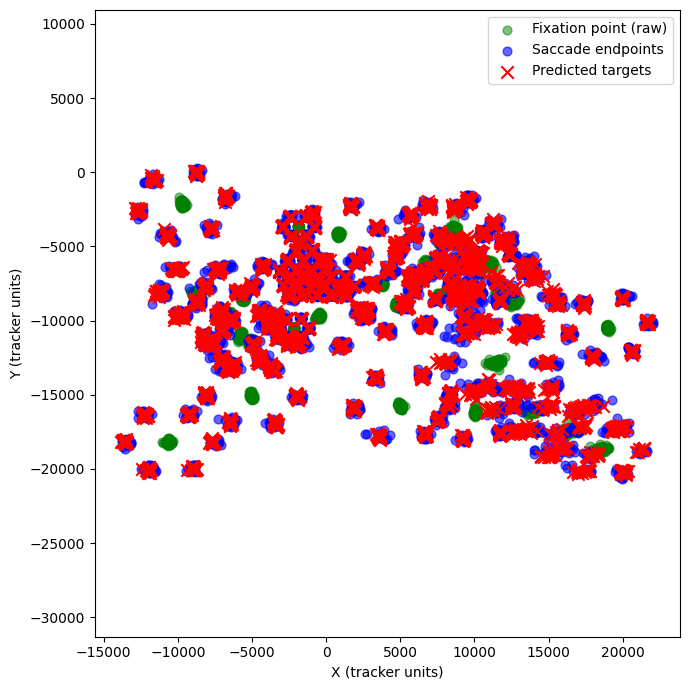

In [29]:
import matplotlib.pyplot as plt

# keep only correct trials with all required values
req = ["endX_raw","endY_raw","targX_raw_pred","targY_raw_pred",
       "responseTime_idx","responseDone_idx","fixBaseX_raw","fixBaseY_raw"]
mask = merged[req].notna().all(axis=1)

plt.figure(figsize=(7,7))

# Fixation baselines (green circles)
plt.scatter(
    merged.loc[mask, "fixBaseX_raw"],
    merged.loc[mask, "fixBaseY_raw"],
    c="green", marker="o", s=40, alpha=0.5, label="Fixation point (raw)"
)

# Endpoints (blue dots)
plt.scatter(
    merged.loc[mask, "endX_raw"],
    merged.loc[mask, "endY_raw"],
    c="blue", s=40, alpha=0.6, label="Saccade endpoints"
)

# Predicted targets (red crosses)
plt.scatter(
    merged.loc[mask, "targX_raw_pred"],
    merged.loc[mask, "targY_raw_pred"],
    c="red", marker="x", s=80, label="Predicted targets"
)

plt.xlabel("X (tracker units)")
plt.ylabel("Y (tracker units)")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


Session 101123: plotting 123 correct trials with all fields present.


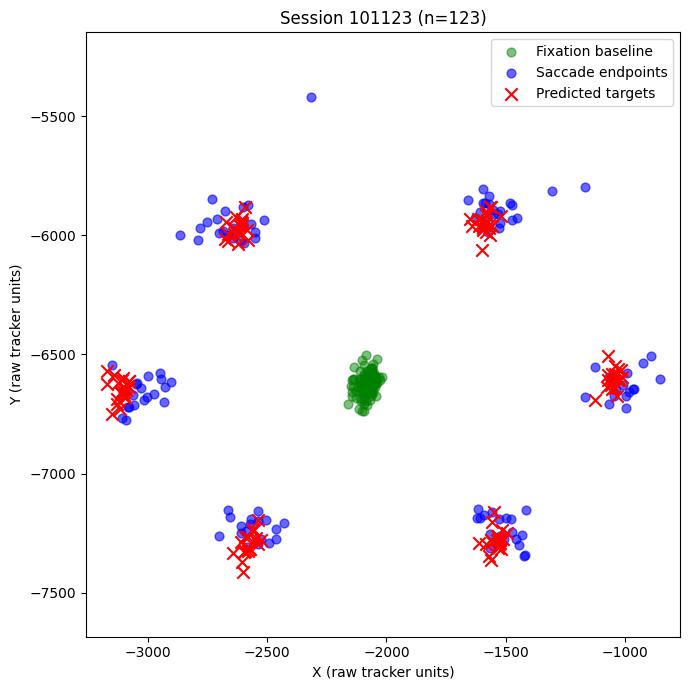

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- choose the session you want to visualize ---
target_session = "101123"  # <-- change this to the session_id you want
sess = merged.loc[merged["session_id"].astype(str) == str(target_session)].copy()

# columns we need for this plot
req = ["fixBaseX_raw","fixBaseY_raw","endX_raw","endY_raw","targX_raw_pred","targY_raw_pred"]

# mask: correct trials with all required values present
mask = sess[req].notna().all(axis=1)

n_points = int(mask.sum())
print(f"Session {target_session}: plotting {n_points} correct trials with all fields present.")
if n_points == 0:
    raise ValueError(f"No valid points to plot for session {target_session}. Check required columns/NaNs.")

plt.figure(figsize=(7,7))

# fixation baselines (green)
plt.scatter(
    sess.loc[mask, "fixBaseX_raw"],
    sess.loc[mask, "fixBaseY_raw"],
    c="green", marker="o", s=40, alpha=0.5, label="Fixation baseline"
)

# endpoints (blue)
plt.scatter(
    sess.loc[mask, "endX_raw"],
    sess.loc[mask, "endY_raw"],
    c="blue", s=40, alpha=0.6, label="Saccade endpoints"
)

# predicted targets (red)
plt.scatter(
    sess.loc[mask, "targX_raw_pred"],
    sess.loc[mask, "targY_raw_pred"],
    c="red", marker="x", s=80, label="Predicted targets"
)

plt.title(f"Session {target_session} (n={n_points})")
plt.xlabel("X (raw tracker units)")
plt.ylabel("Y (raw tracker units)")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# columns needed
req = ["fixBaseX_raw","fixBaseY_raw","endX_raw","endY_raw","targX_raw_pred","targY_raw_pred"]

# get unique session ids (as strings)
sessions = sorted(merged["session_id"].astype(str).unique())

os.makedirs("session_plots", exist_ok=True)

for sid in sessions:
    sess = merged.loc[merged["session_id"].astype(str) == sid].copy()

    # mask: rows with all required values present
    mask = sess[req].notna().all(axis=1)
    n_points = int(mask.sum())

    print(f"Session {sid}: {n_points} valid trials.")
    if n_points == 0:
        continue  # skip plotting empty sessions

    plt.figure(figsize=(7,7))

    # fixation baselines (green)
    plt.scatter(
        sess.loc[mask, "fixBaseX_raw"],
        sess.loc[mask, "fixBaseY_raw"],
        c="green", marker="o", s=40, alpha=0.5, label="Fixation baseline"
    )

    # endpoints (blue)
    plt.scatter(
        sess.loc[mask, "endX_raw"],
        sess.loc[mask, "endY_raw"],
        c="blue", s=40, alpha=0.6, label="Saccade endpoints"
    )

    # predicted targets (red)
    plt.scatter(
        sess.loc[mask, "targX_raw_pred"],
        sess.loc[mask, "targY_raw_pred"],
        c="red", marker="x", s=80, label="Predicted targets"
    )

    plt.title(f"Session {sid} (n={n_points})")
    plt.xlabel("X (raw tracker units)")
    plt.ylabel("Y (raw tracker units)")
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"session_plots/session_{sid}.png", dpi=150)
    plt.close()


Session 100706: 124 valid trials.
Session 100724: 139 valid trials.
Session 100725: 141 valid trials.
Session 100726: 140 valid trials.
Session 100730: 142 valid trials.
Session 100731: 142 valid trials.
Session 100802: 139 valid trials.
Session 100803: 121 valid trials.
Session 100804: 126 valid trials.
Session 100817: 150 valid trials.
Session 100818: 132 valid trials.
Session 100819: 121 valid trials.
Session 100820: 117 valid trials.
Session 100823: 119 valid trials.
Session 100824: 124 valid trials.
Session 100826: 125 valid trials.
Session 100827: 158 valid trials.
Session 100828: 137 valid trials.
Session 101122: 112 valid trials.
Session 101123: 123 valid trials.
Session 101124: 137 valid trials.
Session 101127: 131 valid trials.
Session 101128: 123 valid trials.
Session 101202: 135 valid trials.
Session 101206: 130 valid trials.
Session 101207: 120 valid trials.
Session 101209: 116 valid trials.
Session 101210: 124 valid trials.
Session 101216: 143 valid trials.
Session 110107

In [32]:
import numpy as np
import pandas as pd

def _angle_deg(x, y):
    ang = np.degrees(np.arctan2(y, x))
    return (ang + 180.0) % 360.0 - 180.0  # wrap to (-180, 180]

def add_response_metrics_big(df_trials: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """
    Per session:
      - fit 2x2 map A on correct trials in baseline-relative space (no intercept)
      - compute respEcc/Ang in raw (baseline-relative)
      - transform responses to dva via Ainv, compute respX/Y_dva + respEcc/Ang_dva
    Returns (df_with_cols, per_session_fit) where per_session_fit[sid] = {"A": A, "Ainv": Ainv}.
    """
    # Work on a clean copy with a simple RangeIndex
    df = df_trials.copy().reset_index(drop=True)
    # Normalize session_id to strings (avoid mixed types)
    if "session_id" in df.columns:
        df["session_id"] = df["session_id"].astype(str)

    # Initialize outputs
    out_cols = ["respEcc_raw","respAng_raw","respX_dva","respY_dva","respEcc_dva","respAng_dva"]
    for col in out_cols:
        df[col] = np.nan

    per_session_fit = {}

    needed = ["correct","targX","targY","endX_raw","endY_raw","fixBaseX_raw","fixBaseY_raw"]

    # Iterate over actual group DataFrames (not .groups)
    for sid, rows in df.groupby("session_id", sort=False):
        idx = rows.index  # indices back into df

        # Training mask
        good = (rows["correct"] == 1) & rows[needed].notna().all(axis=1)

        # Baseline-relative responses (all rows)
        R_all = rows[["endX_raw","endY_raw"]].to_numpy(float)
        B_all = rows[["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)
        R_all_rel = R_all - B_all

        # (A) raw response metrics (baseline-relative)
        respEcc_raw = np.hypot(R_all_rel[:,0], R_all_rel[:,1])
        respAng_raw = _angle_deg(R_all_rel[:,0], R_all_rel[:,1])

        # Defaults for dva (NaNs)
        respX_dva = np.full(len(rows), np.nan, float)
        respY_dva = np.full(len(rows), np.nan, float)

        A = None
        Ainv = None

        if np.any(good):
            # Fit A on correct trials in this session
            T = rows.loc[good, ["targX","targY"]].to_numpy(float)               # (N x 2)
            R = rows.loc[good, ["endX_raw","endY_raw"]].to_numpy(float)         # (N x 2)
            B = rows.loc[good, ["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float) # (N x 2)
            R_rel = R - B

            A, *_ = np.linalg.lstsq(T, R_rel, rcond=None)  # (2x2)
            Ainv = np.linalg.pinv(A)

            # (B) transform all responses to dva: T_hat ≈ R_rel @ Ainv
            respXY_dva = R_all_rel @ Ainv
            respX_dva[:] = respXY_dva[:,0]
            respY_dva[:] = respXY_dva[:,1]

        # Write back
        df.loc[idx, "respEcc_raw"] = respEcc_raw
        df.loc[idx, "respAng_raw"] = respAng_raw
        df.loc[idx, "respX_dva"]   = respX_dva
        df.loc[idx, "respY_dva"]   = respY_dva
        df.loc[idx, "respEcc_dva"] = np.hypot(respX_dva, respY_dva)
        df.loc[idx, "respAng_dva"] = _angle_deg(respX_dva, respY_dva)

        per_session_fit[sid] = {"A": A, "Ainv": Ainv}

    return df, per_session_fit

# ----- run it -----
merged, fit_info = add_response_metrics_big(merged)

# Optional: peek at a few sessions’ A
for sid, info in list(fit_info.items())[:3]:
    print(f"[{sid}] A=\n{info['A']}\nAinv=\n{info['Ainv']}\n")


[100706] A=
[[-523.33365265   15.62153824]
 [ -10.22596306 -391.43801519]]
Ainv=
[[-1.90933795e-03 -7.61980048e-05]
 [ 4.98797218e-05 -2.55269229e-03]]

[100724] A=
[[-502.33450242   10.58683161]
 [  12.5954153  -373.75382209]]
Ainv=
[[-1.99212025e-03 -5.64281632e-05]
 [-6.71339808e-05 -2.67745954e-03]]

[100725] A=
[[-511.07349346   11.285805  ]
 [  18.98684508 -356.00638475]]
Ainv=
[[-1.95897288e-03 -6.21016558e-05]
 [-1.04477662e-04 -2.81225045e-03]]



In [33]:
merged.info()
merged['correct'].value_counts()
# merged['correct_trial'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   session_id        4352 non-null   object 
 1   trial_id          4352 non-null   int64  
 2   fixBaseX_raw      4352 non-null   float64
 3   fixBaseY_raw      4352 non-null   float64
 4   endX_raw          4352 non-null   float64
 5   endY_raw          4352 non-null   float64
 6   targX_raw_pred    4352 non-null   float64
 7   targY_raw_pred    4352 non-null   float64
 8   endErr_raw        4352 non-null   float64
 9   taskTrial         4352 non-null   uint16 
 10  bhvTrial          4352 non-null   uint16 
 11  condition         4352 non-null   uint8  
 12  task              4352 non-null   object 
 13  outcome           4352 non-null   object 
 14  correct           4352 non-null   uint8  
 15  reactionTime      4352 non-null   float64
 16  numRewards        4352 non-null   uint8  


correct
1    4352
Name: count, dtype: int64

In [34]:
merged[['targEcc', 'targAng', 'respEcc_dva', 'respAng_dva']]

,targEcc,targAng,respEcc_dva,respAng_dva
0,6.0,0.0,5.538338,4.205191
1,6.0,180.0,6.779916,177.528674
2,6.0,120.0,5.981970,113.474123
3,6.0,120.0,5.780033,114.996894
4,6.0,60.0,6.560382,75.815104
...,...,...,...,...
4347,6.0,120.0,6.620921,122.366152
4348,6.0,0.0,5.462020,1.479437
4349,6.0,0.0,4.383042,-17.932438
4350,6.0,-120.0,5.619182,-115.762451


In [35]:
merged["memoryDelay"] = merged["responseTime"] - merged["targetOff"]

In [36]:
merged[['memoryDelay', 'targAng', 'respAng_dva']]

,memoryDelay,targAng,respAng_dva
0,0.971575,0.0,4.205191
1,0.997950,180.0,177.528674
2,1.035975,120.0,113.474123
3,1.022100,120.0,114.996894
4,1.144175,60.0,75.815104
...,...,...,...
4347,0.787325,120.0,122.366152
4348,0.849250,0.0,1.479437
4349,0.838250,0.0,-17.932438
4350,0.864200,-120.0,-115.762451


In [37]:
df = pd.DataFrame({
    "delay": merged["memoryDelay"],
    "curr": merged["targAng"],
    "resp": merged["respAng_dva"]
})

# Shift targAng by 1 to make prev (first trial will become NaN)
df["prev"] = df["curr"].shift(1)

# Circular distance (prev - curr) in degrees, wrapped to [-180, 180]
def circ_diff(a, b):
    if pd.isna(a) or pd.isna(b):
        return np.nan
    d = (a - b + 180) % 360 - 180
    return d

df["diff"] = [circ_diff(p, c) for p, c in zip(df["prev"], df["curr"])]

df["diff"] = df["diff"].abs()

def circ_err(curr, resp):
    if pd.isna(curr) or pd.isna(resp):
        return np.nan
    d = (curr - resp + 180) % 360 - 180
    return d

df["err"] = [circ_err(c, r) for c, r in zip(df["curr"], df["resp"])]


df


,delay,curr,resp,prev,diff,err
0,0.971575,0.0,4.205191,NaN,NaN,-4.205191
1,0.997950,180.0,177.528674,0.0,180.0,2.471326
2,1.035975,120.0,113.474123,180.0,60.0,6.525877
3,1.022100,120.0,114.996894,120.0,0.0,5.003106
4,1.144175,60.0,75.815104,120.0,60.0,-15.815104
...,...,...,...,...,...,...
4347,0.787325,120.0,122.366152,60.0,60.0,-2.366152
4348,0.849250,0.0,1.479437,120.0,120.0,-1.479437
4349,0.838250,0.0,-17.932438,0.0,0.0,17.932438
4350,0.864200,-120.0,-115.762451,0.0,120.0,-4.237549


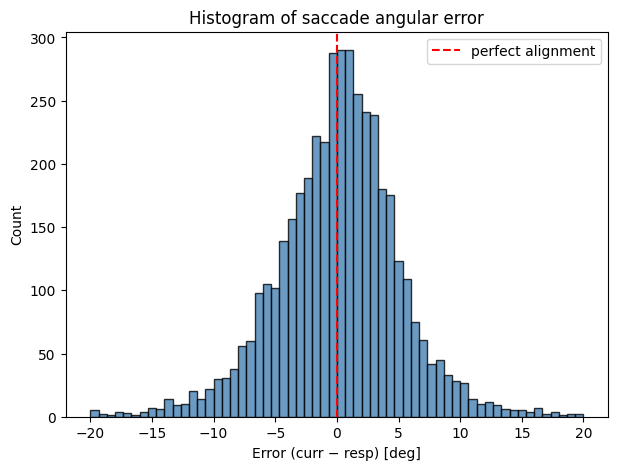

In [38]:
err = df["err"].dropna()

plt.figure(figsize=(7,5))
plt.hist(err, bins=60, range=(-20,20), color="steelblue", alpha=0.8, edgecolor="k")

plt.xlabel("Error (curr − resp) [deg]")
plt.ylabel("Count")
plt.title("Histogram of saccade angular error")
plt.axvline(0, color="red", linestyle="--", label="perfect alignment")
plt.legend()
plt.show()


Delay bins:
delay_bin
(0.753, 0.7532]     25
(0.7532, 0.7546]    19
(0.7546, 0.758]     22
(0.758, 0.7629]     22
(0.7629, 0.7673]    21
                    ..
(1.075, 1.086]      21
(1.086, 1.095]      22
(1.095, 1.1134]     22
(1.1134, 1.1916]    22
(1.1916, 1.6639]    22
Name: count, Length: 200, dtype: int64
0      0.753187
1      0.753816
2      0.756486
3      0.760628
4      0.765661
         ...   
195    1.079317
196    1.090074
197    1.101172
198    1.149498
199    1.356905
Name: delay_mean, Length: 200, dtype: float64


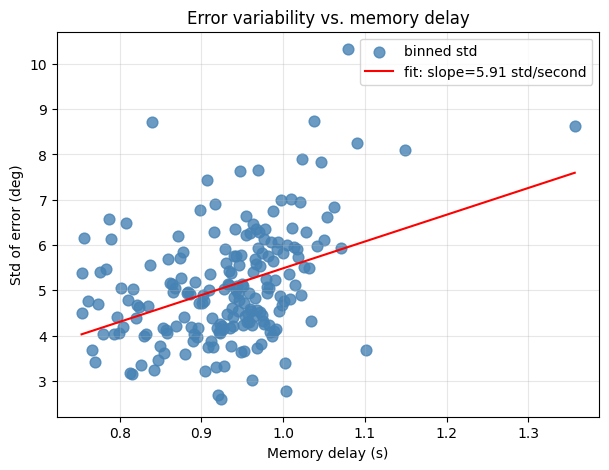

In [39]:
valid = df[["delay","err"]].dropna()

bins = 200
valid["delay_bin"] = pd.qcut(valid["delay"], q=bins, duplicates="drop")

print("Delay bins:")
print(valid["delay_bin"].value_counts().sort_index())

stats = valid.groupby("delay_bin", observed=False).agg(
    delay_mean=("delay","mean"),
    err_std=("err","std")
).reset_index()

plt.figure(figsize=(7,5))
plt.scatter(stats["delay_mean"], stats["err_std"], color="steelblue", s=60, alpha=0.8, label="binned std")

if len(stats) > 2:
    coeffs = np.polyfit(stats["delay_mean"], stats["err_std"], 1)
    print(stats["delay_mean"])
    xs = np.linspace(stats["delay_mean"].min(), stats["delay_mean"].max(), 100)
    ys = np.polyval(coeffs, xs)
    plt.plot(xs, ys, color="red", label=f"fit: slope={coeffs[0]:.2f} std/second")

plt.xlabel("Memory delay (s)")
plt.ylabel("Std of error (deg)")
plt.title("Error variability vs. memory delay")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Diff bins:
diff_bin
(-180, -150]       0
(-150, -120]       0
(-120, -90]        0
(-90, -60]         0
(-60, -30]         0
(-30, 0]         721
(0, 30]            0
(30, 60]        1455
(60, 90]           0
(90, 120]       1448
(120, 150]         0
(150, 180]       727
Name: count, dtype: int64
Bin Center: -165.0, Bin Range: (-180, -150], Diff Values: [], Err Values: []
Bin Center: -135.0, Bin Range: (-150, -120], Diff Values: [], Err Values: []
Bin Center: -105.0, Bin Range: (-120, -90], Diff Values: [], Err Values: []
Bin Center: -75.0, Bin Range: (-90, -60], Diff Values: [], Err Values: []
Bin Center: -45.0, Bin Range: (-60, -30], Diff Values: [], Err Values: []
Bin Center: -15.0, Bin Range: (-30, 0], Diff Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

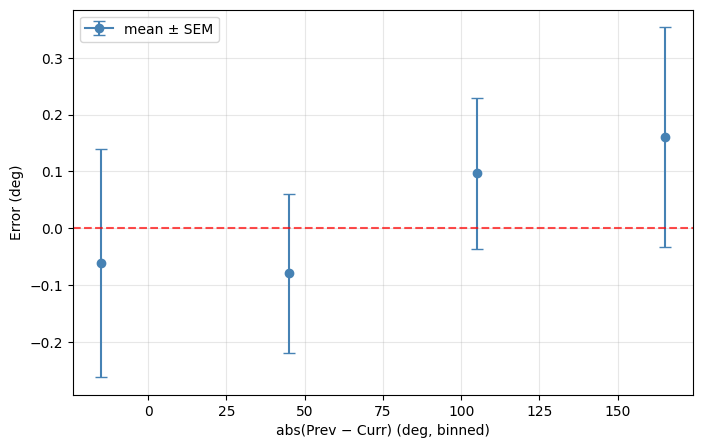

In [40]:
valid = df[["diff","err"]].dropna()

# Bin diff into 30° bins
bin_edges = np.arange(-180, 181, 30)  # edges: -180, -150, ..., 180
valid["diff_bin"] = pd.cut(valid["diff"], bins=bin_edges)
print("Diff bins:")
print(valid["diff_bin"].value_counts().sort_index())

# Compute mean ± SEM of error in each bin
stats = valid.groupby("diff_bin", observed=False)["err"].agg(["mean","count","std"])
stats["sem"] = stats["std"] / np.sqrt(stats["count"])

# Get bin centers for plotting
bin_centers = [interval.mid for interval in stats.index]
for center, interval in zip(bin_centers, stats.index):
    bin_err_values = valid.loc[valid["diff_bin"] == interval, "err"].tolist()
    bin_diff_values = valid.loc[valid["diff_bin"] == interval, "diff"].tolist()
    print(f"Bin Center: {center}, Bin Range: {interval}, Diff Values: {bin_diff_values}, Err Values: {bin_err_values}")

# Plot mean error vs diff bin
plt.figure(figsize=(8,5))
plt.errorbar(bin_centers, stats["mean"], yerr=stats["sem"], 
             fmt="o-", capsize=4, color="steelblue", label="mean ± SEM")

plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("abs(Prev − Curr) (deg, binned)")
plt.ylabel("Error (deg)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
